Tarea 1: Clasificacion y regresion dataset de vinos
- Integrantes:
    - Ana Maria Bolaños 
    - Juan Carlos Mora
    - Jean pierre Henriquez

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder, StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, f1_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict
import joblib
import os

RANDOM_STATE = 42

## 1. EDA

### Objetivo

En esta etapa del **Análisis Exploratorio de Datos** se revisa la estructura, calidad y relaciones internas del conjunto de datos antes de aplicar modelos predictivos.

### Actividades

- Inspección inicial de las variables  
- Identificación de valores atípicos o faltantes  
- Análisis de distribuciones y correlaciones  

In [21]:
#cargar datasets
data_clasificacion = pd.read_csv("../data/wine_data_train_classification.csv")
data_clasificacion = pd.DataFrame(data_clasificacion)

data_regresion = pd.read_csv("../data/wine_data_train_regression.csv")
data_regresion = pd.DataFrame(data_regresion)

print(f"\n🔹 Columnas en clasificacion:\n{data_clasificacion.columns.tolist()}")
print(f"\n🔹 Columnas en regresion:\n{data_regresion.columns.tolist()}")


🔹 Columnas en clasificacion:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'type', 'quality_category', 'quality_label']

🔹 Columnas en regresion:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'type', 'quality']


### 📋 Vista inicial del conjunto de datos
En la tabla se observa una muestra del dataset que contiene variables fisicoquímicas de **vinos blancos y tintos**, junto con su respectiva categoría de calidad.
Cada fila representa una observación individual (una muestra de vino), mientras que las columnas describen características como **acidez**, **azúcar residual**, **dióxido de azufre**, **densidad**, **pH**, **contenido de alcohol** y **tipo de vino**.
La variable `quality_category` será utilizada como **etiqueta de clasificación**, ya que agrupa los vinos en categorías cualitativas de calidad (*Low, Medium, High*).
Este primer vistazo confirma que el dataset está correctamente estructurado y combina tanto variables numéricas como categóricas, lo que permitirá aplicar técnicas de preprocesamiento y modelado supervisado.

In [ ]:
# tamaño de los datasets
print(f"Dimensiones de los datos de clasificacion",data_clasificacion.shape)
print("\n Estadísticas de los datos de clasificacion")
print("-"*60)
estadisticas_classificacion = data_clasificacion.describe()
print(estadisticas_classificacion)

print("-"*60)
print(f"Dimensiones de los datos de clasificacion",data_regresion.shape)
print("\n Estadísticas de los datos de clasificacion")
print("-"*60)
estadisticas_regresion = data_regresion.describe()
print(estadisticas_regresion)

Dimensiones de los datos de clasificacion (5847, 14)

 Estadísticas de los datos de clasificacion
------------------------------------------------------------
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    5847.000000       5847.000000  5847.000000     5847.000000   
mean        7.218616          0.339803     0.318659        5.465401   
std         1.299384          0.164542     0.144632        4.764590   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.200000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  5847.000000          5847.000000           5847.000000  5847.000000   
mean      0.056071            30.671969      

### Verificación de valores nulos
Al analizar el dataset, se comprobó que no existen valores nulos en las variables.
Por tanto, no fue necesario aplicar ningún proceso de imputación ni eliminación de registros.
Esto garantiza que los datos están completos y listos para su uso en los modelos de clasificación y regresión.

In [23]:
valores_nulos_class = data_clasificacion.isnull().sum()
print("Valores nulos en datos de clasificacion:")
print(valores_nulos_class)
print(f"\n Total de valores nulos en los datos de clasificacion: {valores_nulos_class.sum()}")

#valores nulos de regresion
print("="*60)
valores_nulos_regress = data_regresion.isnull().sum()
print("\n Valores nulos en datos de regresion:")
print(valores_nulos_regress)
print(f"\n Total de valores nulos en los datos de regresion: {valores_nulos_regress.sum()}")

Valores nulos en datos de clasificacion:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
type                    0
quality_category        0
quality_label           0
dtype: int64

 Total de valores nulos en los datos de clasificacion: 0

 Valores nulos en datos de regresion:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
type                    0
quality                 0
dtype: int64

 Total de valores nulos en los datos de regresion: 0


### 🎯 Preparación de datos para clasificación y regresión
En esta etapa se separan los datos en dos enfoques de modelado:

- **Clasificación:** se utiliza la variable `quality_category`, que agrupa la calidad del vino en tres clases:
- *Low (≤4)*, *Medium (5–6)* y *High (≥7)*, con mapeo numérico **2**, **1** y **0** respectivamente.
La distribución de clases muestra una predominancia de la categoría *Medium*, lo que indica un leve desbalance de clases que deberá considerarse en el entrenamiento.

- **Regresión:** se emplea la variable `quality` como objetivo continuo, con un rango de valores entre **3 y 9** y una desviación estándar cercana a **0.87**, reflejando una dispersión moderada alrededor del promedio.

Las gráficas confirman que los datos de calidad tienden a concentrarse en niveles medios, tanto para clasificación como para regresión, lo que proporciona una base coherente para los experimentos supervisados posteriores.

------------------------------------------------------------
✅ Variable target para clasificación: 'num' (binaria)
✅ Dimensiones de X_clasificacion: (5847, 13)
✅ Dimensiones de y_clasificacion: (5847,)

📊 Distribución de y_clasificacion:
quality_category
High      1149
Low        222
Medium    4476
Name: count, dtype: int64
------------------------------------------------------------
✅ Variable target para regresión: quality
✅ Dimensiones de X_regresion: (5847, 12)
✅ Dimensiones de y_regresion: (5847,)

 Estadísticas de y_regresion:
count    5847.000000
mean        5.815803
std         0.876053
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64
Desviasion estandar de y_regresion: 0.8760526930950364


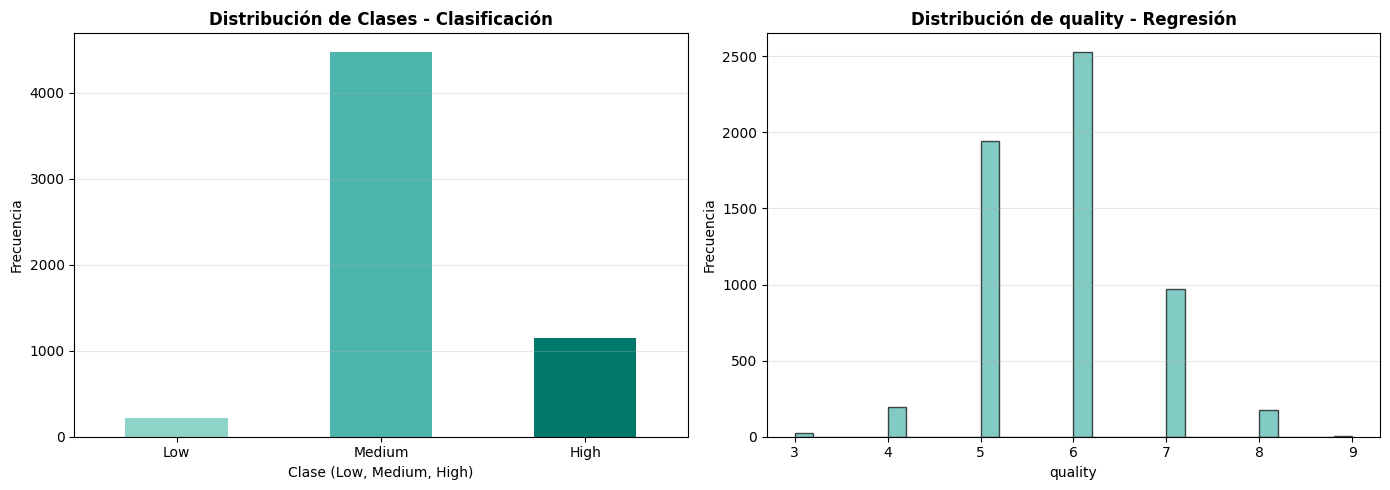

In [24]:
#-------------------------------------------------
#Datos para clasificacion
#-------------------------------------------------
#para clasificacion se va a seleccionar la variable quality_category que tiene las categorias Low - Medium - High
# Categorías:
#Low (Baja):    quality <= 4
#Medium (Media): quality 5-6
#High (Alta):   quality >= 7

#Mapeo numérico:
#Low: 2
#Medium: 1
#High: 0

clasificacion_order = ['Low', 'Medium', 'High']
X_clasificacion = data_clasificacion.drop(columns=['quality_category'])
y_clasificacion = data_clasificacion['quality_category']

print("-"*60)
print(f"✅ Variable target para clasificación: 'num' (binaria)")
print(f"✅ Dimensiones de X_clasificacion: {X_clasificacion.shape}")
print(f"✅ Dimensiones de y_clasificacion: {y_clasificacion.shape}")
print(f"\n📊 Distribución de y_clasificacion:")
print(y_clasificacion.value_counts().sort_index())

#-------------------------------------------------
# Datos para  regresion
#-------------------------------------------------
#la variable target es quality (numérica continua)
# Rango: 3 - 9
print("-"*60)
X_regresion = data_regresion.drop(columns=['quality'])
y_regresion = data_regresion['quality']

print(f"✅ Variable target para regresión: quality")
print(f"✅ Dimensiones de X_regresion: {X_regresion.shape}")
print(f"✅ Dimensiones de y_regresion: {y_regresion.shape}")
print(f"\n Estadísticas de y_regresion:")
print(y_regresion.describe())
print(f"Desviasion estandar de y_regresion: {y_regresion.std()}")


#------------------------------------------------
#grafica de la distribucion de los datos y clases
#------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Distribución de clases (categórica)
colors = ['#8dd3c7', '#4db6ac', '#00796b']
pd.Series(y_clasificacion).value_counts().reindex(clasificacion_order).plot(kind='bar', ax=axes[0], color = colors)
axes[0].set_title('Distribución de Clases - Clasificación', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Clase (Low, Medium, High)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_xticklabels(clasificacion_order, rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Distribución del target para regresión
variable_target_regresion = 'quality'
axes[1].hist(y_regresion.dropna(), bins=30, edgecolor='black', alpha=0.7, color = "#4db6ac")
axes[1].set_title(f'Distribución de {variable_target_regresion} - Regresión', fontsize=12, fontweight='bold')
axes[1].set_xlabel(variable_target_regresion)
axes[1].set_ylabel('Frecuencia')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### 📦 Detección de valores atípicos mediante boxplots
Los *boxplots* permiten visualizar la dispersión y posibles valores atípicos de las variables numéricas en los conjuntos de **clasificación** y **regresión**.
En ambos casos, se identifican *outliers* notorios en las variables `residual sugar`, `free sulfur dioxide` y `total sulfur dioxide`, que muestran colas largas y puntos alejados del rango intercuartílico.
El resto de las variables mantienen distribuciones más compactas y simétricas.
Estos valores extremos son importantes, ya que pueden influir en la media, la varianza y el desempeño de los modelos; por ello, podrían requerir transformaciones o normalización en etapas posteriores del preprocesamiento.

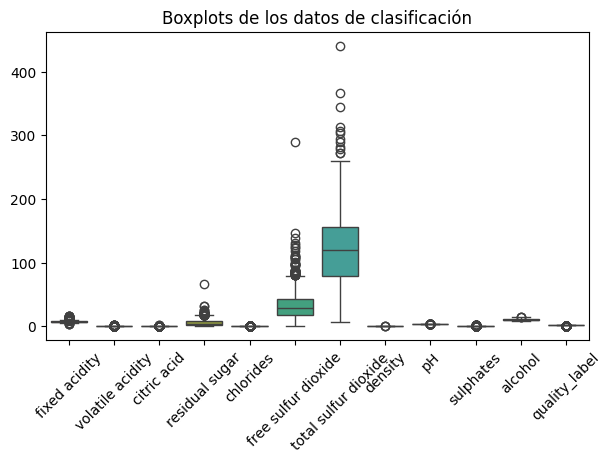

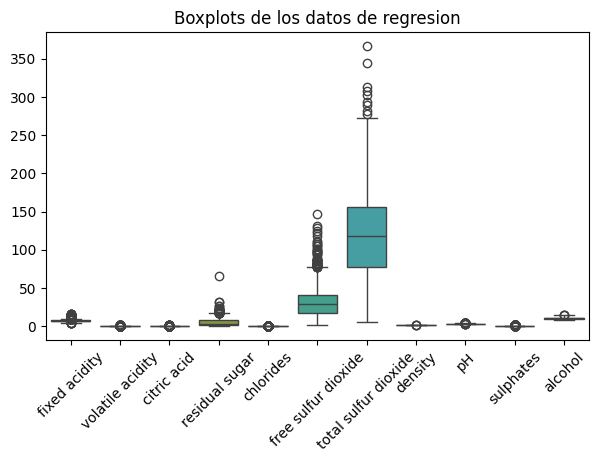

In [29]:
#detección de outliers con boxplots de los datos
plt.figure(figsize=(7,4))
sns.boxplot(data=X_clasificacion.select_dtypes('number'))
plt.xticks(rotation=45)
plt.title('Boxplots de los datos de clasificación')
plt.show()

plt.figure(figsize=(7,4))
sns.boxplot(data=X_regresion.select_dtypes('number'))
plt.xticks(rotation=45)
plt.title('Boxplots de los datos de regresion')
plt.show()

### Encoding

#### 🔡 Codificación de variables categóricas (Encoding)
En esta etapa se realiza la **transformación de variables categóricas** a formato numérico para permitir su uso en los modelos de *Machine Learning*.

- En el dataset de **clasificación**, la variable objetivo `quality_category` se codifica de forma ordinal según el nivel de calidad:
- *High → 0*, *Medium → 1*, *Low → 2*.
Esta codificación respeta el orden lógico de la calidad del vino.

- En ambos conjuntos (**clasificación y regresión**), la variable `type` (vino *red* → 1 o *white* → 0) se convierte a valores numéricos mediante **`LabelEncoder`**, generando una representación binaria que facilita el procesamiento.

Este paso estandariza las variables no numéricas, asegurando que los algoritmos puedan interpretarlas correctamente durante el entrenamiento de los modelos.

In [30]:
#-------------------------------------
#Encoding de datos de clasificacion
#-------------------------------------
data_class_copy = data_clasificacion.copy()
# Variable objetivo (target)
data_class_copy["quality_category"] = data_class_copy["quality_category"].map({
    "High": 0,
    "Medium": 1,
    "Low": 2
})
# Identificar columnas categóricas
categorical_cols_clas = data_class_copy.select_dtypes(include=['object']).columns.tolist()
#display(data_class_copy[categorical_cols_clas].nunique())
le = LabelEncoder()
data_class_copy['type'] = le.fit_transform(data_class_copy['type'])

#---------------------------------
#Encoding de datos de regresion
#---------------------------------
data_regres_copy = data_regresion.copy()
# Identificar columnas categóricas
categorical_cols_reg = data_regres_copy.select_dtypes(include=['object']).columns.tolist()
#display(data_regres_copy[categorical_cols_reg].nunique())
le = LabelEncoder()
data_regres_copy['type'] = le.fit_transform(data_regres_copy['type'])

### Analisis de correlación

Las matrices de correlación permiten evaluar la **relación lineal (Pearson)** y **monotónica (Kendall)** entre las variables numéricas de los conjuntos de **clasificación** y **regresión**.

- En ambos casos, se observa una **alta correlación positiva** entre las variables `free sulfur dioxide` y `total sulfur dioxide`, lo que sugiere que miden aspectos relacionados del proceso de conservación del vino.
- También se evidencia una **correlación negativa** entre `density` y `alcohol`, indicando que a mayor grado alcohólico, menor densidad del vino.
- La variable `volatile acidity` presenta correlaciones negativas moderadas con `citric acid` y `quality`, lo cual concuerda con el hecho de que una acidez volátil elevada suele asociarse con una menor calidad sensorial.

Estos resultados permiten identificar posibles variables redundantes y proporcionan una base sólida para la **selección de características** o la **reducción de dimensionalidad** en etapas posteriores del modelado.

------------------------------------------------------------
Correlaciones de datos de clasificacion
------------------------------------------------------------


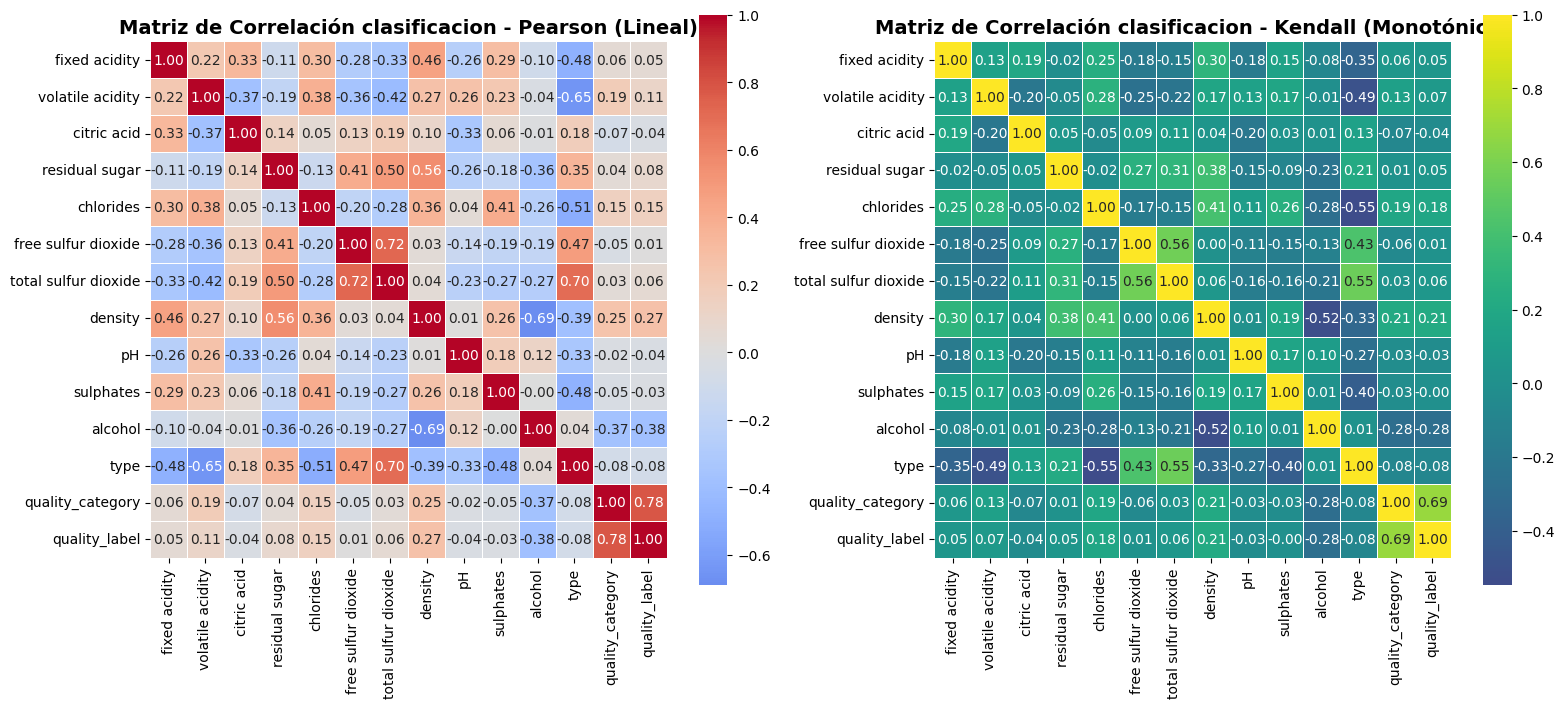

------------------------------------------------------------
Correlaciones de datos de regresion
------------------------------------------------------------


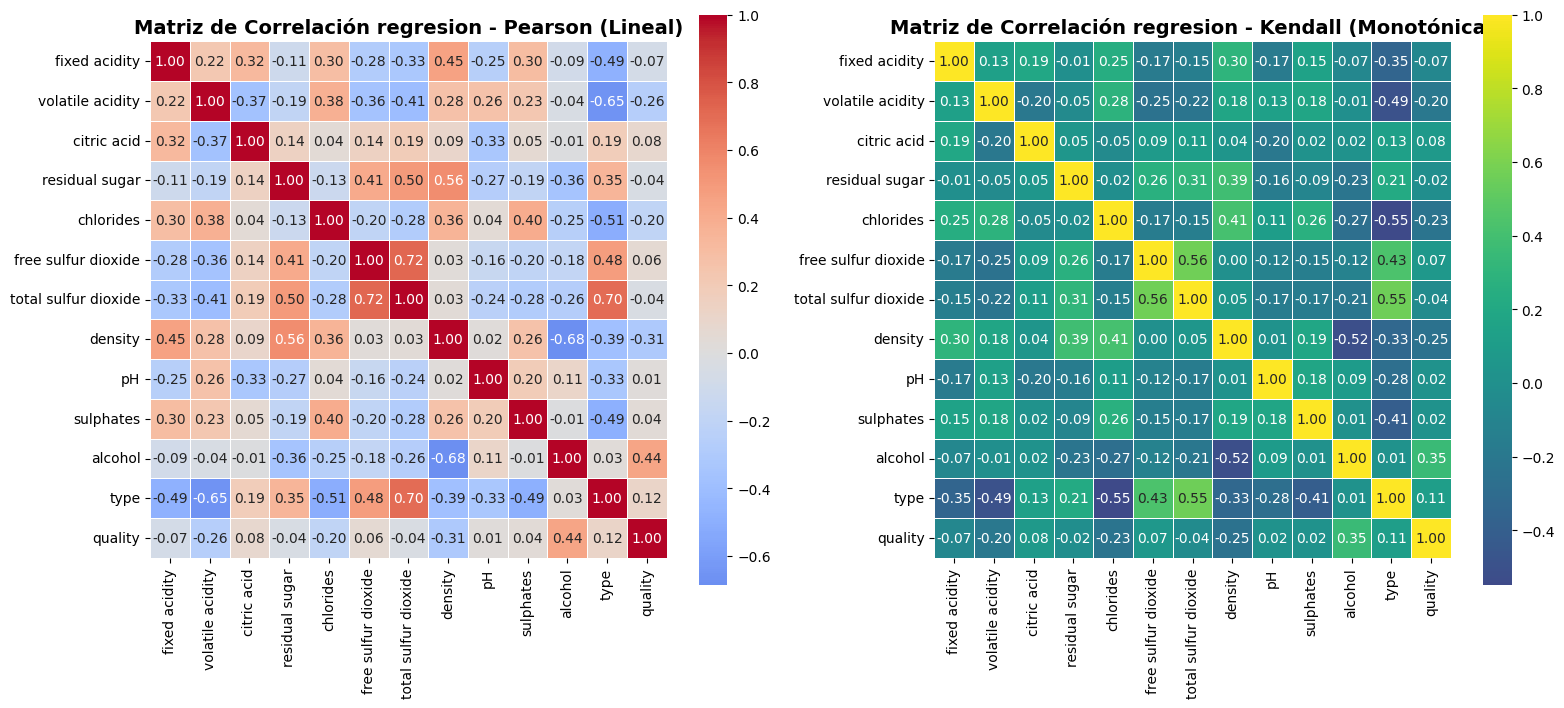

In [31]:
#------------------------------------------
#correlaciones de datos de clasificacion
#------------------------------------------
print("-"*60)
print("Correlaciones de datos de clasificacion")
print("-"*60)

# Crear las dos correlaciones
correlacion_pearson_class = data_class_copy.corr(method='pearson')
correlacion_kendall_class = data_class_copy.corr(method='kendall')

# Crear figura con dos subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

#Gráfica 1: Pearson
sns.heatmap(correlacion_pearson_class, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('Matriz de Correlación clasificacion - Pearson (Lineal)', fontsize=14, fontweight='bold')

#Gráfica 2: Kendall
sns.heatmap(correlacion_kendall_class, annot=True, fmt='.2f', cmap='viridis',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=axes[1])
axes[1].set_title('Matriz de Correlación clasificacion - Kendall (Monotónica)', fontsize=14, fontweight='bold')

# Ajustar el diseño para que no se sobrepongan los textos
plt.tight_layout()
plt.show()


#------------------------------------------
#correlaciones de datos de regresion
#------------------------------------------
print("-"*60)
print("Correlaciones de datos de regresion")
print("-"*60)

# Crear las dos correlaciones
correlacion_pearson_regres = data_regres_copy.corr(method='pearson')
correlacion_kendall_regres = data_regres_copy.corr(method='kendall')

# Crear figura con dos subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

#Gráfica 1: Pearson
sns.heatmap(correlacion_pearson_regres, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('Matriz de Correlación regresion - Pearson (Lineal)', fontsize=14, fontweight='bold')

#Gráfica 2: Kendall
sns.heatmap(correlacion_kendall_regres, annot=True, fmt='.2f', cmap='viridis',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=axes[1])
axes[1].set_title('Matriz de Correlación regresion - Kendall (Monotónica)', fontsize=14, fontweight='bold')

# Ajustar el diseño para que no se sobrepongan los textos
plt.tight_layout()
plt.show()


### Seleccion de variables y eliminacion por correlacion
Después del análisis de correlación, se determinó qué variables debían eliminarse para evitar la multicolinealidad y, con ello, reducir el riesgo de overfitting.
El umbral de correlación seleccionado fue **0.7**, es decir, si dos variables presentaban una correlación mayor a este valor, se eliminó una de ellas.

- **Datos de clasificación:** se eliminaron las variables `['total sulfur dioxide', 'quality_label']`.
    - *Nota:* la variable `quality_label` era equivalente a `quality_category` (el **target**), pero en formato numérico.
- **Datos de regresión:** se eliminaron las variables `['total sulfur dioxide', 'type']`.

Este proceso permitió conservar solo las variables con mayor aporte explicativo y menor redundancia en el modelo.



In [32]:
#------------------------------------------
#Eliminar variables con correlacion alta
#------------------------------------------
def eliminar_correlacion_alta(df, umbral=0.8):
  # TODO: Calcula la matriz de correlación con el método abs() para valores absolutos
    corr_matrix = df.corr(method='pearson').abs()

    # Crear conjunto para guardar variables a eliminar
    variables_eliminar = set()

    # Recorrer la matriz triangular superior
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # TODO: Verifica si la correlación es mayor al umbral
            if corr_matrix.iloc[i, j] > umbral:
                nombre_variable = corr_matrix.columns[i]
                variables_eliminar.add(nombre_variable)
                print(f"Correlación alta detectada: {corr_matrix.columns[j]} vs {nombre_variable} = {corr_matrix.iloc[i, j]:.3f}")

    # TODO: Elimina las columnas del DataFrame
    df_filtrado = df.drop(columns=variables_eliminar)

    return df_filtrado, list(variables_eliminar)

#-------------------------------------------------------
#Eliminacion de variables alta correlacion clasificacion
#-------------------------------------------------------
# Aplicar la función de eliminar cariables de correlacion alta en los datos de clasificacion
print('-'*80)
print("Eliminacion de variables de correlacion alta en datos de clasificacion")
print('-'*80)
Data_class_filtrado, vars_eliminadas_class = eliminar_correlacion_alta(data_class_copy, umbral=0.7)

print("Eliminacion de variables de correlacion alta en datos de clasificacion")
print(f"\n📊 Variables originales: {data_class_copy.shape[1]}")
print(f"📊 Variables eliminadas: {len(vars_eliminadas_class)}")
print(f"📊 Variables restantes: {Data_class_filtrado.shape[1]}")

if len(vars_eliminadas_class) > 0:
    print(f"\n🗑️ Variables eliminadas por alta correlación en datos de clasificiacion: {vars_eliminadas_class}")
else:
    print(f"\n✅ No se eliminaron variables (ninguna con correlación > 0.7)")

print(f"\n✅ Variables finales para el modelo:")
print(Data_class_filtrado.columns.tolist())


#-------------------------------------------------------
#Eliminacion de variables alta correlacion regresion
#-------------------------------------------------------
print('\n','-'*80)
print("Eliminacion de variables de correlacion alta en datos de regresion")
print('-'*80)
# Aplicar la función de eliminar variables de correlacion alta en los datos de regresion
Data_regres_filtrado, vars_eliminadas_regres = eliminar_correlacion_alta(data_regres_copy, umbral=0.7)

print("Eliminacion de variables de correlacion alta en datos de regresion")
print(f"\n📊 Variables originales: {data_regres_copy.shape[1]}")
print(f"📊 Variables eliminadas: {len(vars_eliminadas_regres)}")
print(f"📊 Variables restantes: {Data_regres_filtrado.shape[1]}")

if len(vars_eliminadas_regres) > 0:
    print(f"\n🗑️ Variables eliminadas por alta correlación en datos de regresion: {vars_eliminadas_regres}")
else:
    print(f"\n✅ No se eliminaron variables (ninguna con correlación > 0.7)")

print(f"\n✅ Variables finales para el modelo:")
print(Data_regres_filtrado.columns.tolist())

--------------------------------------------------------------------------------
Eliminacion de variables de correlacion alta en datos de clasificacion
--------------------------------------------------------------------------------
Correlación alta detectada: free sulfur dioxide vs total sulfur dioxide = 0.723
Correlación alta detectada: quality_category vs quality_label = 0.784
Eliminacion de variables de correlacion alta en datos de clasificacion

📊 Variables originales: 14
📊 Variables eliminadas: 2
📊 Variables restantes: 12

🗑️ Variables eliminadas por alta correlación en datos de clasificiacion: ['quality_label', 'total sulfur dioxide']

✅ Variables finales para el modelo:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'type', 'quality_category']

 --------------------------------------------------------------------------------
Eliminacion de variables de correlacion alta en datos 

In [37]:
data_clasificacion_filtrada = Data_class_filtrado.to_csv("../data/wine_data_train_classification_filtrado.csv", index=False, encoding='utf-8')
data_regresion_filtrada = Data_regres_filtrado.to_csv("../data/wine_data_train_regression_filtrado.csv", index=False, encoding='utf-8')